In [1]:
import pandas as pd
import numpy as np
from fmiopendata.wfs import download_stored_query
import datetime as dt
import os

#### This is for one data file

We fill all Nan values by using the geographically closest stations, fit a 1d polynomial between the closest and the current station and apply the fitted function to the closest station values to fill the Nan values.

In [2]:
# Assuming 'df' is your DataFrame loaded from a CSV file
# Replace 'your_data.csv' with the path to your actual CSV file
file_path='data_by_measurement_type/air_temperature_data.csv'

timestamp_column = 'Timestamp'

# Read the CSV file, setting the timestamp column as the index
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

missing_values = df.isnull().sum()

print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Alajärvi Möksy                         1
Asikkala Pulkkilanharju                7
Eckerö Torp                         3910
Enontekiö Kilpisjärvi Saana          253
Enontekiö Kilpisjärvi kyläkeskus     254
                                    ... 
Virolahti Koivuniemi                   1
Virrat Äijänneva                       6
Ylitornio Meltosjärvi                 42
Ylivieska lentokenttä                 22
Ähtäri Inha                            0
Length: 223, dtype: int64


In [16]:

# Function to find the closest station with non-NaN values
def find_closest_station(current_station, stations_metadata, df, excluded_stations):
    min_distance = float('inf')
    closest_station = None
    for station, metadata in stations_metadata.items():
        if station != current_station and station not in excluded_stations and not df[station].isnull().all():
            distance = np.sqrt((metadata['longitude'] - stations_metadata[current_station]['longitude'])**2 +
                               (metadata['latitude'] - stations_metadata[current_station]['latitude'])**2)
            if distance < min_distance:
                min_distance = distance
                closest_station = station
    return closest_station

# Function to fill NaN values using polyfit from the closest station
def fill_nan_values(station, stations_metadata, df):
    nan_indices = df[station][df[station].isnull()].index
    excluded_stations = []
    
    while len(nan_indices) > 0:
        closest_station_name = find_closest_station(station, stations_metadata, df, excluded_stations)
        print(closest_station_name)
        
        if closest_station_name is None:  # No more stations to check
            break
            
        excluded_stations.append(closest_station_name)
        series_a = df[station]
        series_b = df[closest_station_name]

        # Find indices where either series A or B has NaN values
        nan_indices = series_a[series_a.isnull() | series_b.isnull()].index

        # Remove the NaN values from both series
        clean_a = series_a.drop(nan_indices)
        clean_b = series_b.drop(nan_indices)
        if len(clean_a)==0 or  len(clean_b)==0:
            return

        # Ensure both series are of the same length after dropping NaN values
        assert len(clean_a) == len(clean_b), "The series are not of the same length after dropping NaN values."

        # Perform polynomial fit on the cleaned data
        coeffs = np.polyfit(clean_a, clean_b, 1)  # Degree can be adjusted
        poly = np.poly1d(coeffs)

        # Fill NaN values in station A using the polynomial function and values from station B
        for idx in df[station][df[station].isnull()].index:
            if not np.isnan(df.at[idx, closest_station_name]):
                filled_value = round(poly(df.at[idx, closest_station_name]), 2)
                df.at[idx, station] = filled_value
                
        nan_indices = df[station][df[station].isnull()].index
        print(f"Filled NaN values for station {station} using {closest_station_name}. Remaining NaN count: {len(nan_indices)}")

    

# Retrieve station metadata
end_time = dt.datetime.utcnow()
start_time = end_time - dt.timedelta(hours=1)
obs = download_stored_query("fmi::observations::weather::multipointcoverage",
                            args=["bbox=18,55,35,75",
                                  "starttime=" + start_time.isoformat(timespec="seconds") + "Z",
                                  "endtime=" + end_time.isoformat(timespec="seconds") + "Z"])

stations_metadata = {station: metadata for station, metadata in obs.location_metadata.items()}

# Main loop to fill NaN values for each station
for station in df.columns:
    if station in stations_metadata:
        fill_nan_values(station, stations_metadata, df)


Halsua Purola
Filled NaN values for station Alajärvi Möksy using Halsua Purola. Remaining NaN count: 0
Lahti Sopenkorpi
Filled NaN values for station Asikkala Pulkkilanharju using Lahti Sopenkorpi. Remaining NaN count: 7
Luhanka Judinsalo
Filled NaN values for station Asikkala Pulkkilanharju using Luhanka Judinsalo. Remaining NaN count: 6
Hämeenlinna Lammi Pappila
Filled NaN values for station Asikkala Pulkkilanharju using Hämeenlinna Lammi Pappila. Remaining NaN count: 0
Enontekiö Kilpisjärvi kyläkeskus
Filled NaN values for station Enontekiö Kilpisjärvi Saana using Enontekiö Kilpisjärvi kyläkeskus. Remaining NaN count: 253
Enontekiö lentoasema
Filled NaN values for station Enontekiö Kilpisjärvi Saana using Enontekiö lentoasema. Remaining NaN count: 252
Enontekiö Näkkälä
Filled NaN values for station Enontekiö Kilpisjärvi Saana using Enontekiö Näkkälä. Remaining NaN count: 252
Muonio Oustajärvi
Filled NaN values for station Enontekiö Kilpisjärvi Saana using Muonio Oustajärvi. Remainin

Filled NaN values for station Ilmajoki Seinäjoki lentoasema using Seinäjoki Pelmaa. Remaining NaN count: 1
Kauhava lentokenttä
Filled NaN values for station Ilmajoki Seinäjoki lentoasema using Kauhava lentokenttä. Remaining NaN count: 1
Karvia Alkkia
Filled NaN values for station Ilmajoki Seinäjoki lentoasema using Karvia Alkkia. Remaining NaN count: 0
Ilomantsi Mekrijärvi
Filled NaN values for station Ilomantsi Pötsönvaara using Ilomantsi Mekrijärvi. Remaining NaN count: 0
Kittilä Pokka
Filled NaN values for station Inari Angeli Lintupuoliselkä using Kittilä Pokka. Remaining NaN count: 245
Kittilä Pakatti
Filled NaN values for station Inari Angeli Lintupuoliselkä using Kittilä Pakatti. Remaining NaN count: 245
Kittilä lentoasema
Filled NaN values for station Inari Angeli Lintupuoliselkä using Kittilä lentoasema. Remaining NaN count: 245
Utsjoki Kevo
Filled NaN values for station Inari Angeli Lintupuoliselkä using Utsjoki Kevo. Remaining NaN count: 245
Utsjoki Kevo Kevojärvi
Filled NaN

Kristiinankaupunki Majakka
Filled NaN values for station Kaskinen Sälgrund using Kristiinankaupunki Majakka. Remaining NaN count: 0
Seinäjoki Pelmaa
Filled NaN values for station Kauhajoki Kuja-Kokko using Seinäjoki Pelmaa. Remaining NaN count: 1
Kankaanpää Niinisalo lentokenttä
Filled NaN values for station Kauhajoki Kuja-Kokko using Kankaanpää Niinisalo lentokenttä. Remaining NaN count: 0
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Kauhava lentokenttä using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Kemi Kemi-Tornio lentoasema
Filled NaN values for station Kemi Ajos using Kemi Kemi-Tornio lentoasema. Remaining NaN count: 35
Tornio Torppi
Filled NaN values for station Kemi Ajos using Tornio Torppi. Remaining NaN count: 35
Kemi I majakka
Filled NaN values for station Kemi Ajos using Kemi I majakka. Remaining NaN count: 30
Hailuoto Marjaniemi
Filled NaN values for station Kemi Ajos using Hailuoto Marjaniemi. Remaining NaN count: 0
Tornio Torppi
Filled NaN valu

Kuusamo Rukatunturi
Filled NaN values for station Kuusamo Ruka Talvijärvi using Kuusamo Rukatunturi. Remaining NaN count: 35
Kuusamo Välikangas
Filled NaN values for station Kuusamo Ruka Talvijärvi using Kuusamo Välikangas. Remaining NaN count: 35
Kuusamo lentoasema
Filled NaN values for station Kuusamo Ruka Talvijärvi using Kuusamo lentoasema. Remaining NaN count: 35
Kuusamo Kiutaköngäs
Filled NaN values for station Kuusamo Ruka Talvijärvi using Kuusamo Kiutaköngäs. Remaining NaN count: 0
Kuusamo Ruka Talvijärvi
Filled NaN values for station Kuusamo Rukatunturi using Kuusamo Ruka Talvijärvi. Remaining NaN count: 0
Kuusamo lentoasema
Filled NaN values for station Kuusamo Välikangas using Kuusamo lentoasema. Remaining NaN count: 201
Kuusamo Rukatunturi
Filled NaN values for station Kuusamo Välikangas using Kuusamo Rukatunturi. Remaining NaN count: 0
Kuusamo Välikangas
Filled NaN values for station Kuusamo lentoasema using Kuusamo Välikangas. Remaining NaN count: 0
Lemland Nyhamn
Filled 

Filled NaN values for station Rauma Pyynpää using Rauma Kylmäpihlaja. Remaining NaN count: 0
Rovaniemi lentoasema AWOS
Filled NaN values for station Rovaniemi Apukka using Rovaniemi lentoasema AWOS. Remaining NaN count: 42
Rovaniemi lentoasema
Filled NaN values for station Rovaniemi Apukka using Rovaniemi lentoasema. Remaining NaN count: 42
Rovaniemi rautatieasema
Filled NaN values for station Rovaniemi Apukka using Rovaniemi rautatieasema. Remaining NaN count: 42
Ranua lentokenttä
Filled NaN values for station Rovaniemi Apukka using Ranua lentokenttä. Remaining NaN count: 0
Rovaniemi lentoasema AWOS
Filled NaN values for station Rovaniemi lentoasema using Rovaniemi lentoasema AWOS. Remaining NaN count: 43
Rovaniemi rautatieasema
Filled NaN values for station Rovaniemi lentoasema using Rovaniemi rautatieasema. Remaining NaN count: 42
Rovaniemi Apukka
Filled NaN values for station Rovaniemi lentoasema using Rovaniemi Apukka. Remaining NaN count: 0
Rovaniemi lentoasema
Filled NaN values 

In [17]:
# check if successful

In [18]:
missing_values = df.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Alajärvi Möksy                         0
Asikkala Pulkkilanharju                0
Eckerö Torp                         3910
Enontekiö Kilpisjärvi Saana            0
Enontekiö Kilpisjärvi kyläkeskus       0
                                    ... 
Virolahti Koivuniemi                   0
Virrat Äijänneva                       0
Ylitornio Meltosjärvi                  0
Ylivieska lentokenttä                  0
Ähtäri Inha                            0
Length: 223, dtype: int64


In [19]:
#write df back to file

In [23]:
try:
    os.makedirs('infilled_data/data_by_measurement_type/')
except:
    pass
output_file_path = 'infilled_data/data_by_measurement_type/air_temperature_data.csv.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_file_path, sep=',', index=True)

print(f"DataFrame written to '{output_file_path}'")

DataFrame written to 'infilled_data/data_by_measurement_type/air_temperature_data.csv.csv'


#### plot how many stations have missing values

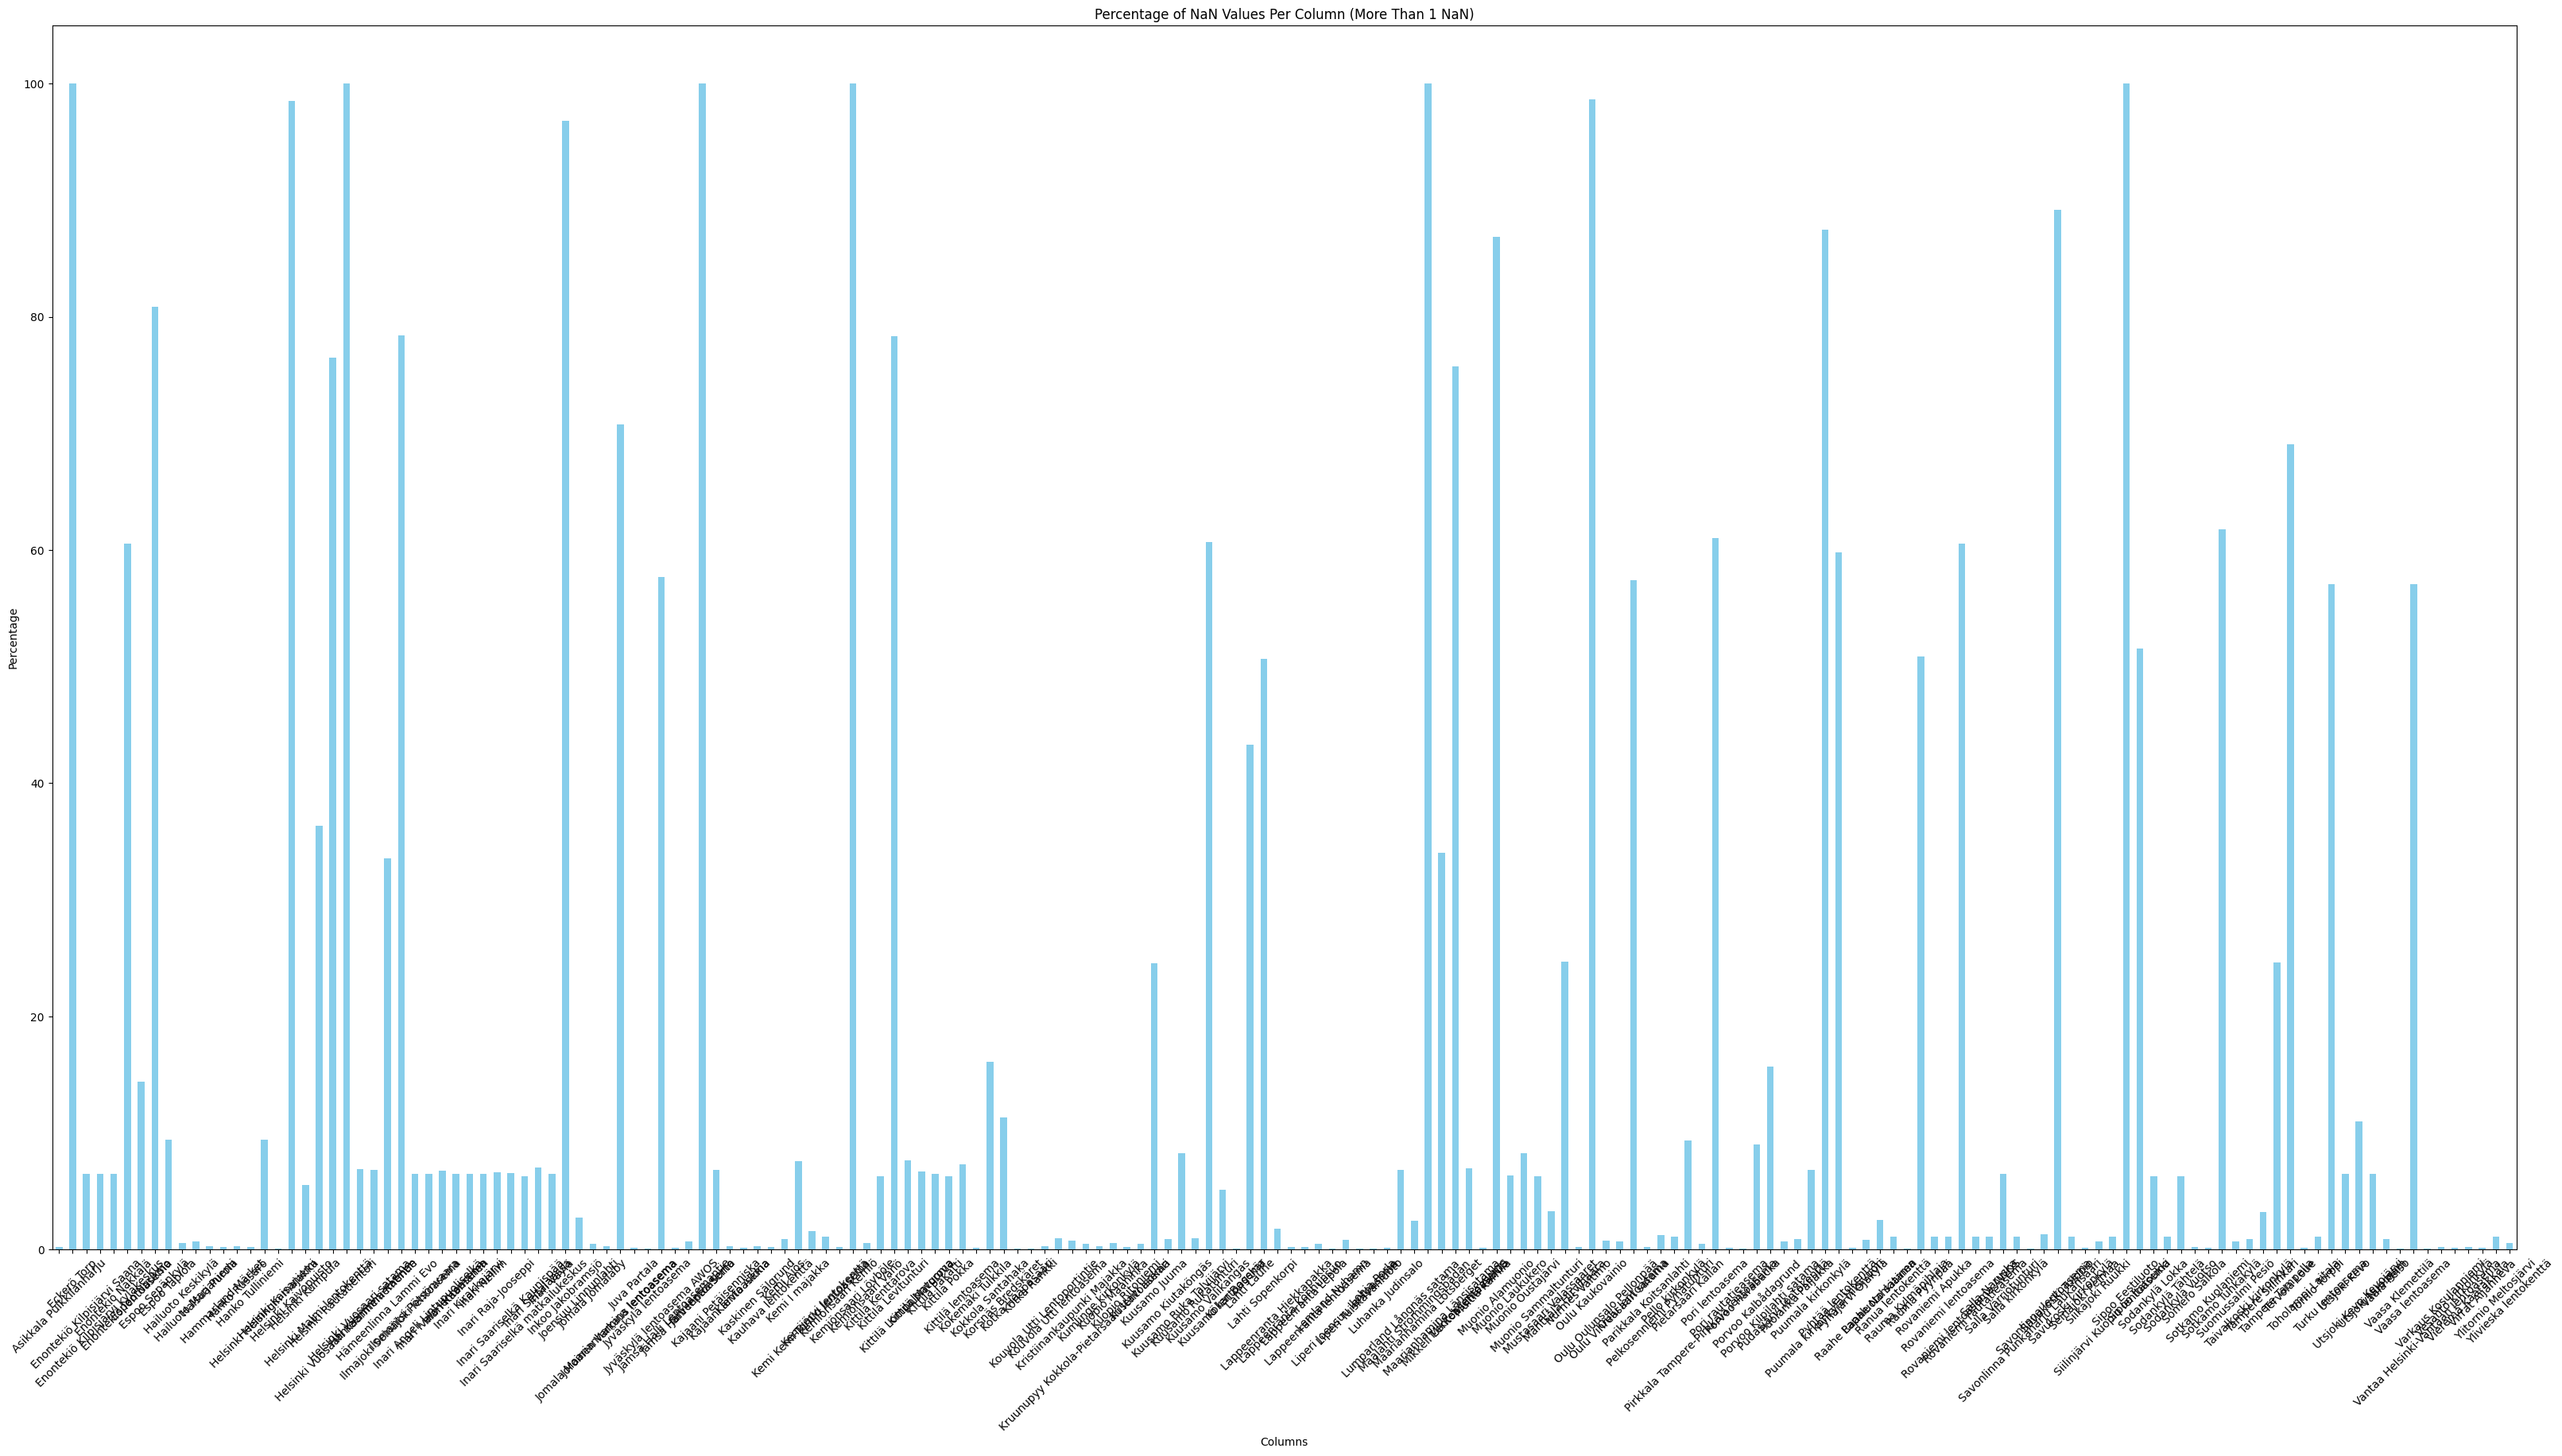

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the percentage of NaN values per column
nan_percentage = (df.isnull().sum() / df.shape[0]) * 100

# Filter to include only columns with more than 1 NaN value
columns_with_nans = nan_percentage[nan_percentage > (1/df.shape[0] * 100)].index

# Plotting only for columns with more than 1 NaN value
plt.figure(figsize=(40, 20))
nan_percentage[columns_with_nans].plot(kind='bar', color='skyblue')
plt.title('Percentage of NaN Values Per Column (More Than 1 NaN)')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


### This does all files

In [14]:
import os
import glob
import pandas as pd
import numpy as np
from fmiopendata.wfs import download_stored_query
import datetime as dt

def read_and_preprocess(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    missing_values = df.isnull().sum()
    print("Missing values in each column:")
    print(missing_values)
    return df

def retrieve_station_metadata():
    end_time = dt.datetime.utcnow()
    start_time = end_time - dt.timedelta(hours=1)
    obs = download_stored_query("fmi::observations::weather::multipointcoverage",
                                args=["bbox=18,55,35,75",
                                      "starttime=" + start_time.isoformat(timespec="seconds") + "Z",
                                      "endtime=" + end_time.isoformat(timespec="seconds") + "Z"])
    return {station: metadata for station, metadata in obs.location_metadata.items()}

def process_file(file_path, stations_metadata):
    df = read_and_preprocess(file_path)
    for station in df.columns:
        if station in stations_metadata:
            fill_nan_values(station, stations_metadata, df)
    return df

def write_to_disk(df, output_file_path):
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
    df.to_csv(output_file_path, sep=',', index=True)
    print(f"DataFrame written to '{output_file_path}'")

# Functions find_closest_station and fill_nan_values as you defined them go here

# Main logic to process all files in a folder
data_folder_path = 'data_by_measurement_type'
output_folder_path = 'infilled_data/data_by_measurement_type'

stations_metadata = retrieve_station_metadata()

for file_name in glob.glob(os.path.join(data_folder_path, '*.csv')):
    print(f"Processing file: {file_name}")
    processed_df = process_file(file_name, stations_metadata)
    output_file_name = os.path.basename(file_name).replace('.csv', '_filled.csv')
    output_file_path = os.path.join(output_folder_path, output_file_name)
    write_to_disk(processed_df, output_file_path)

Processing file: data_by_measurement_type/precipitation_amount_data.csv
Missing values in each column:
Alajärvi Möksy                         2
Asikkala Pulkkilanharju             1483
Eckerö Torp                         1483
Enontekiö Kilpisjärvi Saana         1483
Enontekiö Kilpisjärvi kyläkeskus       7
                                    ... 
Virolahti Koivuniemi                   4
Virrat Äijänneva                    1483
Ylitornio Meltosjärvi                  0
Ylivieska lentokenttä                  0
Ähtäri Inha                            0
Length: 223, dtype: int64
Ähtäri Inha
Filled NaN values for station Alajärvi Möksy using Ähtäri Inha. Remaining NaN count: 0
Lahti Sopenkorpi
Enontekiö Kilpisjärvi kyläkeskus
Enontekiö Näkkälä
Filled NaN values for station Enontekiö Kilpisjärvi kyläkeskus using Enontekiö Näkkälä. Remaining NaN count: 0
Muonio Oustajärvi
Filled NaN values for station Enontekiö Näkkälä using Muonio Oustajärvi. Remaining NaN count: 0
Enontekiö Näkkälä
Nurmijärvi

Filled NaN values for station Savukoski Tulppio using Salla Värriötunturi. Remaining NaN count: 0
Sodankylä Lokka
Filled NaN values for station Savukoski kirkonkylä using Sodankylä Lokka. Remaining NaN count: 1
Salla kirkonkylä
Filled NaN values for station Savukoski kirkonkylä using Salla kirkonkylä. Remaining NaN count: 0
Kauhava lentokenttä
Filled NaN values for station Seinäjoki Pelmaa using Kauhava lentokenttä. Remaining NaN count: 0
Kuopio Savilahti
Helsinki Kumpula
Sodankylä Vuotso
Filled NaN values for station Sodankylä Lokka using Sodankylä Vuotso. Remaining NaN count: 0
Kemijärvi lentokenttä
Filled NaN values for station Sodankylä Tähtelä using Kemijärvi lentokenttä. Remaining NaN count: 0
Inari Saariselkä matkailukeskus
Filled NaN values for station Sodankylä Vuotso using Inari Saariselkä matkailukeskus. Remaining NaN count: 0
Salo Kiikala lentokenttä
Filled NaN values for station Somero Salkola using Salo Kiikala lentokenttä. Remaining NaN count: 0
Sotkamo Kuolaniemi
Filled

Hanko Russarö
Hämeenlinna Katinen
Asikkala Pulkkilanharju
Helsinki Kaisaniemi
Filled NaN values for station Helsinki Harmaja using Helsinki Kaisaniemi. Remaining NaN count: 0
Helsinki Harmaja
Filled NaN values for station Helsinki Helsingin majakka using Helsinki Harmaja. Remaining NaN count: 0
Helsinki Kumpula
Filled NaN values for station Helsinki Kaisaniemi using Helsinki Kumpula. Remaining NaN count: 0
Helsinki Kaisaniemi
Filled NaN values for station Helsinki Kumpula using Helsinki Kaisaniemi. Remaining NaN count: 0
Helsinki Kumpula
Filled NaN values for station Helsinki Malmi lentokenttä using Helsinki Kumpula. Remaining NaN count: 0
Helsinki Vuosaari satama
Sipoo Itätoukki
Filled NaN values for station Helsinki Vuosaari satama using Sipoo Itätoukki. Remaining NaN count: 218
Helsinki Malmi lentokenttä
Filled NaN values for station Helsinki Vuosaari satama using Helsinki Malmi lentokenttä. Remaining NaN count: 0
Vantaa Helsinki-Vantaan lentoasema
Vihti Maasoja
Filled NaN values fo

Filled NaN values for station Jyväskylä lentoasema AWOS using Jyväskylä lentoasema. Remaining NaN count: 0
Jämsä Halli lentoasema
Multia Karhila
Filled NaN values for station Jämsä Halli lentoasema using Multia Karhila. Remaining NaN count: 0
Mäntsälä Hirvihaara
Kemiönsaari Kemiö
Filled NaN values for station Kaarina Yltöinen using Kemiönsaari Kemiö. Remaining NaN count: 13
Turku lentoasema
Filled NaN values for station Kaarina Yltöinen using Turku lentoasema. Remaining NaN count: 1
Turku Artukainen
Filled NaN values for station Kaarina Yltöinen using Turku Artukainen. Remaining NaN count: 0
Kajaani lentoasema
Filled NaN values for station Kajaani Petäisenniska using Kajaani lentoasema. Remaining NaN count: 13
Sotkamo Tuhkakylä
Filled NaN values for station Kajaani Petäisenniska using Sotkamo Tuhkakylä. Remaining NaN count: 13
Puolanka Paljakka
Filled NaN values for station Kajaani Petäisenniska using Puolanka Paljakka. Remaining NaN count: 0
Kajaani Petäisenniska
Filled NaN values for

Filled NaN values for station Loviisa Orrengrund using Kotka Rankki. Remaining NaN count: 0
Asikkala Pulkkilanharju
Filled NaN values for station Luhanka Judinsalo using Asikkala Pulkkilanharju. Remaining NaN count: 0
Jomala Jomalaby
Filled NaN values for station Lumparland Långnäs satama using Jomala Jomalaby. Remaining NaN count: 0
Korsnäs Bredskäret
Filled NaN values for station Maalahti Strömmingsbådan using Korsnäs Bredskäret. Remaining NaN count: 0
Maarianhamina Länsisatama
Filled NaN values for station Maarianhamina Lotsberget using Maarianhamina Länsisatama. Remaining NaN count: 248
Jomala Maarianhamina lentoasema
Filled NaN values for station Maarianhamina Lotsberget using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Maarianhamina Lotsberget
Filled NaN values for station Maarianhamina Länsisatama using Maarianhamina Lotsberget. Remaining NaN count: 0
Mikkeli lentoasema
Filled NaN values for station Mikkeli Lentoasema AWOS using Mikkeli lentoasema. Remaining NaN coun

Filled NaN values for station Savukoski Tulppio using Salla Naruska. Remaining NaN count: 0
Sodankylä Lokka
Filled NaN values for station Savukoski kirkonkylä using Sodankylä Lokka. Remaining NaN count: 9
Salla kirkonkylä
Filled NaN values for station Savukoski kirkonkylä using Salla kirkonkylä. Remaining NaN count: 0
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Seinäjoki Pelmaa using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Oulu lentoasema
Filled NaN values for station Siikajoki Ruukki using Oulu lentoasema. Remaining NaN count: 0
Kuopio Savilahti
Filled NaN values for station Siilinjärvi Kuopio lentoasema using Kuopio Savilahti. Remaining NaN count: 0
Helsinki Vuosaari satama
Filled NaN values for station Sipoo Itätoukki using Helsinki Vuosaari satama. Remaining NaN count: 0
Sodankylä Vuotso
Filled NaN values for station Sodankylä Lokka using Sodankylä Vuotso. Remaining NaN count: 204
Inari Saariselkä Kaunispää
Filled NaN values for station Sodankylä Lokka

Espoo Tapiola
Filled NaN values for station Espoo Nuuksio using Espoo Tapiola. Remaining NaN count: 2
Helsinki Kaisaniemi
Filled NaN values for station Espoo Nuuksio using Helsinki Kaisaniemi. Remaining NaN count: 0
Helsinki Kaisaniemi
Filled NaN values for station Espoo Tapiola using Helsinki Kaisaniemi. Remaining NaN count: 3
Helsinki Kumpula
Filled NaN values for station Espoo Tapiola using Helsinki Kumpula. Remaining NaN count: 0
Pyhäjärvi Ojakylä
Hailuoto Marjaniemi
Filled NaN values for station Hailuoto Keskikylä using Hailuoto Marjaniemi. Remaining NaN count: 10
Raahe Lapaluoto satama
Filled NaN values for station Hailuoto Keskikylä using Raahe Lapaluoto satama. Remaining NaN count: 0
Hailuoto Keskikylä
Filled NaN values for station Hailuoto Marjaniemi using Hailuoto Keskikylä. Remaining NaN count: 0
Toholampi Laitala
Filled NaN values for station Halsua Purola using Toholampi Laitala. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Hammarlan

Inari Väylä
Filled NaN values for station Inari Seitalaassa using Inari Väylä. Remaining NaN count: 215
Inari Ivalo lentoasema
Filled NaN values for station Inari Seitalaassa using Inari Ivalo lentoasema. Remaining NaN count: 0
Inari Seitalaassa
Filled NaN values for station Inari Väylä using Inari Seitalaassa. Remaining NaN count: 0
Inkoo Jakobramsjö
Filled NaN values for station Inkoo Bågaskär using Inkoo Jakobramsjö. Remaining NaN count: 29
Kirkkonummi Mäkiluoto
Filled NaN values for station Inkoo Bågaskär using Kirkkonummi Mäkiluoto. Remaining NaN count: 0
Inkoo Bågaskär
Filled NaN values for station Inkoo Jakobramsjö using Inkoo Bågaskär. Remaining NaN count: 0
Liperi Tuiskavanluoto
Somero Salkola
Filled NaN values for station Jokioinen Ilmala using Somero Salkola. Remaining NaN count: 1
Salo Kiikala lentokenttä
Filled NaN values for station Jokioinen Ilmala using Salo Kiikala lentokenttä. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Jomala 

Filled NaN values for station Kuusamo Juuma using Kuusamo Rukatunturi. Remaining NaN count: 3
Kuusamo lentoasema
Filled NaN values for station Kuusamo Juuma using Kuusamo lentoasema. Remaining NaN count: 0
Kuusamo Juuma
Kuusamo Rukatunturi
Kuusamo lentoasema
Filled NaN values for station Kuusamo Rukatunturi using Kuusamo lentoasema. Remaining NaN count: 1
Kuusamo Juuma
Filled NaN values for station Kuusamo Rukatunturi using Kuusamo Juuma. Remaining NaN count: 0
Kuusamo lentoasema
Kuusamo Rukatunturi
Filled NaN values for station Kuusamo lentoasema using Kuusamo Rukatunturi. Remaining NaN count: 0
Lemland Nyhamn
Filled NaN values for station Kökar Bogskär using Lemland Nyhamn. Remaining NaN count: 0
Asikkala Pulkkilanharju
Lappeenranta Konnunsuo
Filled NaN values for station Lappeenranta Hiekkapakka using Lappeenranta Konnunsuo. Remaining NaN count: 43
Lappeenranta Lepola
Filled NaN values for station Lappeenranta Hiekkapakka using Lappeenranta Lepola. Remaining NaN count: 0
Lappeenrant

Filled NaN values for station Savukoski Tulppio using Salla Naruska. Remaining NaN count: 0
Sodankylä Lokka
Filled NaN values for station Savukoski kirkonkylä using Sodankylä Lokka. Remaining NaN count: 11
Salla kirkonkylä
Filled NaN values for station Savukoski kirkonkylä using Salla kirkonkylä. Remaining NaN count: 0
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Seinäjoki Pelmaa using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Oulu lentoasema
Filled NaN values for station Siikajoki Ruukki using Oulu lentoasema. Remaining NaN count: 0
Kuopio Savilahti
Filled NaN values for station Siilinjärvi Kuopio lentoasema using Kuopio Savilahti. Remaining NaN count: 0
Helsinki Vuosaari satama
Filled NaN values for station Sipoo Itätoukki using Helsinki Vuosaari satama. Remaining NaN count: 0
Sodankylä Vuotso
Filled NaN values for station Sodankylä Lokka using Sodankylä Vuotso. Remaining NaN count: 204
Inari Saariselkä Kaunispää
Filled NaN values for station Sodankylä Lokk

Filled NaN values for station Enontekiö Kilpisjärvi Saana using Raahe Nahkiainen. Remaining NaN count: 21
Kalajoki Ulkokalla
Filled NaN values for station Enontekiö Kilpisjärvi Saana using Kalajoki Ulkokalla. Remaining NaN count: 0
Enontekiö Kilpisjärvi Saana
Filled NaN values for station Enontekiö Kilpisjärvi kyläkeskus using Enontekiö Kilpisjärvi Saana. Remaining NaN count: 0
Enontekiö lentoasema
Filled NaN values for station Enontekiö Näkkälä using Enontekiö lentoasema. Remaining NaN count: 252
Muonio Oustajärvi
Filled NaN values for station Enontekiö Näkkälä using Muonio Oustajärvi. Remaining NaN count: 252
Muonio Laukukero
Filled NaN values for station Enontekiö Näkkälä using Muonio Laukukero. Remaining NaN count: 245
Muonio Sammaltunturi
Filled NaN values for station Enontekiö Näkkälä using Muonio Sammaltunturi. Remaining NaN count: 245
Kittilä Lompolonvuoma
Filled NaN values for station Enontekiö Näkkälä using Kittilä Lompolonvuoma. Remaining NaN count: 245
Kittilä Matorova
Fill

Utsjoki Kevo Kevojärvi
Filled NaN values for station Inari Ivalo lentoasema using Utsjoki Kevo Kevojärvi. Remaining NaN count: 245
Utsjoki Kevo
Filled NaN values for station Inari Ivalo lentoasema using Utsjoki Kevo. Remaining NaN count: 245
Sodankylä Tähtelä
Filled NaN values for station Inari Ivalo lentoasema using Sodankylä Tähtelä. Remaining NaN count: 42
Savukoski kirkonkylä
Filled NaN values for station Inari Ivalo lentoasema using Savukoski kirkonkylä. Remaining NaN count: 42
Utsjoki Nuorgam
Filled NaN values for station Inari Ivalo lentoasema using Utsjoki Nuorgam. Remaining NaN count: 42
Pelkosenniemi Pyhätunturi
Filled NaN values for station Inari Ivalo lentoasema using Pelkosenniemi Pyhätunturi. Remaining NaN count: 42
Kittilä Pokka
Filled NaN values for station Inari Ivalo lentoasema using Kittilä Pokka. Remaining NaN count: 42
Inari Angeli Lintupuoliselkä
Filled NaN values for station Inari Ivalo lentoasema using Inari Angeli Lintupuoliselkä. Remaining NaN count: 0
Inari V

Muonio Sammaltunturi
Filled NaN values for station Kittilä Kenttärova using Muonio Sammaltunturi. Remaining NaN count: 245
Muonio Laukukero
Filled NaN values for station Kittilä Kenttärova using Muonio Laukukero. Remaining NaN count: 245
Muonio Oustajärvi
Filled NaN values for station Kittilä Kenttärova using Muonio Oustajärvi. Remaining NaN count: 245
Kittilä lentoasema
Filled NaN values for station Kittilä Kenttärova using Kittilä lentoasema. Remaining NaN count: 245
Kittilä Pakatti
Filled NaN values for station Kittilä Kenttärova using Kittilä Pakatti. Remaining NaN count: 245
Enontekiö lentoasema
Filled NaN values for station Kittilä Kenttärova using Enontekiö lentoasema. Remaining NaN count: 0
Kittilä Matorova
Filled NaN values for station Kittilä Lompolonvuoma using Kittilä Matorova. Remaining NaN count: 245
Kittilä Kenttärova
Filled NaN values for station Kittilä Lompolonvuoma using Kittilä Kenttärova. Remaining NaN count: 0
Kittilä Kenttärova
Filled NaN values for station Kitti

Filled NaN values for station Mikkeli Lentoasema AWOS using Mikkeli lentoasema. Remaining NaN count: 271
Juva Partala
Filled NaN values for station Mikkeli Lentoasema AWOS using Juva Partala. Remaining NaN count: 0
Mikkeli Lentoasema AWOS
Filled NaN values for station Mikkeli lentoasema using Mikkeli Lentoasema AWOS. Remaining NaN count: 0
Jämsä Halli Lentoasemantie
Filled NaN values for station Multia Karhila using Jämsä Halli Lentoasemantie. Remaining NaN count: 0
Muonio Sammaltunturi
Filled NaN values for station Muonio Laukukero using Muonio Sammaltunturi. Remaining NaN count: 245
Kittilä Lompolonvuoma
Filled NaN values for station Muonio Laukukero using Kittilä Lompolonvuoma. Remaining NaN count: 0
Muonio Laukukero
Filled NaN values for station Muonio Oustajärvi using Muonio Laukukero. Remaining NaN count: 0
Kittilä Lompolonvuoma
Filled NaN values for station Muonio Sammaltunturi using Kittilä Lompolonvuoma. Remaining NaN count: 0
Korsnäs Bredskäret
Filled NaN values for station M

Parikkala Koitsanlahti
Filled NaN values for station Savonlinna Punkaharju Laukansaari using Parikkala Koitsanlahti. Remaining NaN count: 0
Rantasalmi Rukkasluoto
Filled NaN values for station Savonlinna lentoasema using Rantasalmi Rukkasluoto. Remaining NaN count: 0
Salla Värriötunturi
Filled NaN values for station Savukoski Tulppio using Salla Värriötunturi. Remaining NaN count: 0
Sodankylä Lokka
Filled NaN values for station Savukoski kirkonkylä using Sodankylä Lokka. Remaining NaN count: 42
Salla kirkonkylä
Filled NaN values for station Savukoski kirkonkylä using Salla kirkonkylä. Remaining NaN count: 0
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Seinäjoki Pelmaa using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Oulu lentoasema
Filled NaN values for station Siikajoki Ruukki using Oulu lentoasema. Remaining NaN count: 0
Kuopio Savilahti
Filled NaN values for station Siilinjärvi Kuopio lentoasema using Kuopio Savilahti. Remaining NaN count: 0
Helsinki Vuosaa

Filled NaN values for station Espoo Tapiola using Helsinki Kaisaniemi. Remaining NaN count: 3
Helsinki Kumpula
Filled NaN values for station Espoo Tapiola using Helsinki Kumpula. Remaining NaN count: 0
Pyhäjärvi Ojakylä
Hailuoto Marjaniemi
Filled NaN values for station Hailuoto Keskikylä using Hailuoto Marjaniemi. Remaining NaN count: 10
Raahe Lapaluoto satama
Filled NaN values for station Hailuoto Keskikylä using Raahe Lapaluoto satama. Remaining NaN count: 0
Hailuoto Keskikylä
Filled NaN values for station Hailuoto Marjaniemi using Hailuoto Keskikylä. Remaining NaN count: 0
Toholampi Laitala
Filled NaN values for station Halsua Purola using Toholampi Laitala. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Hammarland Märket using Jomala Maarianhamina lentoasema. Remaining NaN count: 2
Maarianhamina Länsisatama
Filled NaN values for station Hammarland Märket using Maarianhamina Länsisatama. Remaining NaN count: 0
Hanko Tulliniemi
Filled NaN values 

Inkoo Jakobramsjö
Filled NaN values for station Inkoo Bågaskär using Inkoo Jakobramsjö. Remaining NaN count: 29
Kirkkonummi Mäkiluoto
Filled NaN values for station Inkoo Bågaskär using Kirkkonummi Mäkiluoto. Remaining NaN count: 0
Inkoo Bågaskär
Filled NaN values for station Inkoo Jakobramsjö using Inkoo Bågaskär. Remaining NaN count: 0
Liperi Tuiskavanluoto
Somero Salkola
Filled NaN values for station Jokioinen Ilmala using Somero Salkola. Remaining NaN count: 1
Salo Kiikala lentokenttä
Filled NaN values for station Jokioinen Ilmala using Salo Kiikala lentokenttä. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Jomala Jomalaby using Jomala Maarianhamina lentoasema. Remaining NaN count: 1
Maarianhamina Lotsberget
Filled NaN values for station Jomala Jomalaby using Maarianhamina Lotsberget. Remaining NaN count: 1
Maarianhamina Länsisatama
Filled NaN values for station Jomala Jomalaby using Maarianhamina Länsisatama. Remaining NaN count: 0
Maarianhami

Filled NaN values for station Kuusamo Juuma using Kuusamo Rukatunturi. Remaining NaN count: 3
Kuusamo lentoasema
Filled NaN values for station Kuusamo Juuma using Kuusamo lentoasema. Remaining NaN count: 0
Kuusamo Juuma
Kuusamo Rukatunturi
Kuusamo lentoasema
Filled NaN values for station Kuusamo Rukatunturi using Kuusamo lentoasema. Remaining NaN count: 1
Kuusamo Juuma
Filled NaN values for station Kuusamo Rukatunturi using Kuusamo Juuma. Remaining NaN count: 0
Kuusamo lentoasema
Kuusamo Rukatunturi
Filled NaN values for station Kuusamo lentoasema using Kuusamo Rukatunturi. Remaining NaN count: 0
Lemland Nyhamn
Filled NaN values for station Kökar Bogskär using Lemland Nyhamn. Remaining NaN count: 0
Asikkala Pulkkilanharju
Lappeenranta Konnunsuo
Filled NaN values for station Lappeenranta Hiekkapakka using Lappeenranta Konnunsuo. Remaining NaN count: 42
Lappeenranta Lepola
Filled NaN values for station Lappeenranta Hiekkapakka using Lappeenranta Lepola. Remaining NaN count: 0
Lappeenrant

Savonlinna lentoasema
Filled NaN values for station Rantasalmi Rukkasluoto using Savonlinna lentoasema. Remaining NaN count: 1
Puumala kirkonkylä
Filled NaN values for station Rantasalmi Rukkasluoto using Puumala kirkonkylä. Remaining NaN count: 0
Rovaniemi Apukka
Filled NaN values for station Ranua lentokenttä using Rovaniemi Apukka. Remaining NaN count: 0
Pori Tahkoluoto satama
Filled NaN values for station Rauma Kylmäpihlaja using Pori Tahkoluoto satama. Remaining NaN count: 0
Rauma Kylmäpihlaja
Juuka Niemelä
Filled NaN values for station Rautavaara Ylä-Luosta using Juuka Niemelä. Remaining NaN count: 0
Rovaniemi lentoasema AWOS
Filled NaN values for station Rovaniemi Apukka using Rovaniemi lentoasema AWOS. Remaining NaN count: 19
Rovaniemi lentoasema
Filled NaN values for station Rovaniemi Apukka using Rovaniemi lentoasema. Remaining NaN count: 16
Rovaniemi rautatieasema
Filled NaN values for station Rovaniemi Apukka using Rovaniemi rautatieasema. Remaining NaN count: 7
Ranua lento

Filled NaN values for station Kotka Rankki using Kotka Haapasaari. Remaining NaN count: 0
Kouvola Utti lentoasema
Kouvola Utti lentoasema
Kaskinen Sälgrund
Kuopio Savilahti
Siilinjärvi Kuopio lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Lemland Nyhamn
Lappeenranta Lepola
Lappeenranta Lepola
Jomala Maarianhamina lentoasema
Filled NaN values for station Lemland Nyhamn using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Liperi Joensuu lentoasema
Joensuu Linnunlahti
Inkoo Jakobramsjö
Jyväskylä lentoasema AWOS
Jomala Jomalaby
Kaskinen Sälgrund
Jomala Maarianhamina lentoasema
Jomala Maarianhamina lentoasema
Jämsä Halli lentoasema
Muonio Sammaltunturi
Muonio Sammaltunturi
Filled NaN values for station Muonio Oustajärvi using Muonio Sammaltunturi. Remaining NaN count: 0
Muonio Oustajärvi
Filled NaN values for station Muonio Sammaltunturi using Muonio Oustajärvi. Remaining NaN count: 0
Vaasa Klemettilä
Oulu Vihreäsaari satam

Kemi I majakka
Filled NaN values for station Hailuoto Keskikylä using Kemi I majakka. Remaining NaN count: 21
Kemi Kemi-Tornio lentoasema
Filled NaN values for station Hailuoto Keskikylä using Kemi Kemi-Tornio lentoasema. Remaining NaN count: 21
Oulu Kaukovainio
Filled NaN values for station Hailuoto Keskikylä using Oulu Kaukovainio. Remaining NaN count: 21
Raahe Nahkiainen
Filled NaN values for station Hailuoto Keskikylä using Raahe Nahkiainen. Remaining NaN count: 21
Ylivieska lentokenttä
Filled NaN values for station Hailuoto Keskikylä using Ylivieska lentokenttä. Remaining NaN count: 0
Hailuoto Keskikylä
Filled NaN values for station Hailuoto Marjaniemi using Hailuoto Keskikylä. Remaining NaN count: 0
Alajärvi Möksy
Filled NaN values for station Halsua Purola using Alajärvi Möksy. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Hammarland Märket using Jomala Maarianhamina lentoasema. Remaining NaN count: 8
Maarianhamina Länsisatama
Filled NaN va

Inari Kaamanen
Filled NaN values for station Inari Väylä using Inari Kaamanen. Remaining NaN count: 0
Inkoo Jakobramsjö
Filled NaN values for station Inkoo Bågaskär using Inkoo Jakobramsjö. Remaining NaN count: 0
Inkoo Bågaskär
Filled NaN values for station Inkoo Jakobramsjö using Inkoo Bågaskär. Remaining NaN count: 0
Liperi Tuiskavanluoto
Filled NaN values for station Joensuu Linnunlahti using Liperi Tuiskavanluoto. Remaining NaN count: 0
Somero Salkola
Filled NaN values for station Jokioinen Ilmala using Somero Salkola. Remaining NaN count: 0
Jomala Maarianhamina lentoasema
Filled NaN values for station Jomala Jomalaby using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Maarianhamina Länsisatama
Filled NaN values for station Jomala Maarianhamina lentoasema using Maarianhamina Länsisatama. Remaining NaN count: 11
Jomala Jomalaby
Filled NaN values for station Jomala Maarianhamina lentoasema using Jomala Jomalaby. Remaining NaN count: 0
Luhanka Judinsalo
Filled NaN values for

Pori lentoasema
Filled NaN values for station Kokemäki Tulkkila using Pori lentoasema. Remaining NaN count: 6
Kankaanpää Niinisalo lentokenttä
Filled NaN values for station Kokemäki Tulkkila using Kankaanpää Niinisalo lentokenttä. Remaining NaN count: 0
Kruunupyy Kokkola-Pietarsaari lentoasema
Filled NaN values for station Kokkola Santahaka using Kruunupyy Kokkola-Pietarsaari lentoasema. Remaining NaN count: 1
Kokkola Tankar
Filled NaN values for station Kokkola Santahaka using Kokkola Tankar. Remaining NaN count: 0
Kokkola Santahaka
Filled NaN values for station Kokkola Tankar using Kokkola Santahaka. Remaining NaN count: 0
Maalahti Strömmingsbådan
Filled NaN values for station Korsnäs Bredskäret using Maalahti Strömmingsbådan. Remaining NaN count: 14
Vaasa Klemettilä
Filled NaN values for station Korsnäs Bredskäret using Vaasa Klemettilä. Remaining NaN count: 0
Kotka Rankki
Filled NaN values for station Kotka Haapasaari using Kotka Rankki. Remaining NaN count: 1
Virolahti Koivuniemi


Filled NaN values for station Oulu Kaukovainio using Oulu Vihreäsaari satama. Remaining NaN count: 29
Oulu Oulunsalo Pellonpää
Filled NaN values for station Oulu Kaukovainio using Oulu Oulunsalo Pellonpää. Remaining NaN count: 28
Oulu lentoasema
Filled NaN values for station Oulu Kaukovainio using Oulu lentoasema. Remaining NaN count: 28
Siikajoki Ruukki
Filled NaN values for station Oulu Kaukovainio using Siikajoki Ruukki. Remaining NaN count: 28
Hailuoto Keskikylä
Filled NaN values for station Oulu Kaukovainio using Hailuoto Keskikylä. Remaining NaN count: 0
Oulu lentoasema
Filled NaN values for station Oulu Oulunsalo Pellonpää using Oulu lentoasema. Remaining NaN count: 30
Oulu Vihreäsaari satama
Filled NaN values for station Oulu Oulunsalo Pellonpää using Oulu Vihreäsaari satama. Remaining NaN count: 28
Oulu Kaukovainio
Filled NaN values for station Oulu Oulunsalo Pellonpää using Oulu Kaukovainio. Remaining NaN count: 0
Oulu Oulunsalo Pellonpää
Filled NaN values for station Oulu Vi

Filled NaN values for station Savukoski Tulppio using Salla Värriötunturi. Remaining NaN count: 0
Sodankylä Lokka
Filled NaN values for station Savukoski kirkonkylä using Sodankylä Lokka. Remaining NaN count: 42
Salla kirkonkylä
Filled NaN values for station Savukoski kirkonkylä using Salla kirkonkylä. Remaining NaN count: 0
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Seinäjoki Pelmaa using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Oulu lentoasema
Filled NaN values for station Siikajoki Ruukki using Oulu lentoasema. Remaining NaN count: 0
Kuopio Savilahti
Filled NaN values for station Siilinjärvi Kuopio lentoasema using Kuopio Savilahti. Remaining NaN count: 0
Helsinki Vuosaari satama
Filled NaN values for station Sipoo Itätoukki using Helsinki Vuosaari satama. Remaining NaN count: 0
Sodankylä Vuotso
Filled NaN values for station Sodankylä Lokka using Sodankylä Vuotso. Remaining NaN count: 245
Inari Saariselkä matkailukeskus
Filled NaN values for station Sod

Filled NaN values for station Kokkola Santahaka using Kauhava lentokenttä. Remaining NaN count: 0
Kokkola Santahaka
Vaasa Klemettilä
Kotka Rankki
Kouvola Anjala
Filled NaN values for station Kotka Rankki using Kouvola Anjala. Remaining NaN count: 0
Kouvola Utti Lentoportintie
Filled NaN values for station Kouvola Anjala using Kouvola Utti Lentoportintie. Remaining NaN count: 2
Pyhtää lentokenttä
Filled NaN values for station Kouvola Anjala using Pyhtää lentokenttä. Remaining NaN count: 0
Kouvola Anjala
Filled NaN values for station Kouvola Utti Lentoportintie using Kouvola Anjala. Remaining NaN count: 0
Kouvola Utti Lentoportintie
Kaskinen Sälgrund
Kokkola Santahaka
Lumparland Långnäs satama
Kuopio Savilahti
Filled NaN values for station Kuopio Maaninka using Kuopio Savilahti. Remaining NaN count: 0
Kuopio Savilahti
Rauma Pyynpää
Filled NaN values for station Kustavi Isokari using Rauma Pyynpää. Remaining NaN count: 0
Kuusamo Kiutaköngäs
Kuusamo Välikangas
Filled NaN values for station

Filled NaN values for station Kotka Rankki using Kotka Haapasaari. Remaining NaN count: 0
Kouvola Utti lentoasema
Kouvola Utti lentoasema
Kaskinen Sälgrund
Kuopio Savilahti
Siilinjärvi Kuopio lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Kuusamo lentoasema
Lemland Nyhamn
Lappeenranta Lepola
Lappeenranta Lepola
Jomala Maarianhamina lentoasema
Filled NaN values for station Lemland Nyhamn using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Liperi Joensuu lentoasema
Joensuu Linnunlahti
Inkoo Jakobramsjö
Jyväskylä lentoasema AWOS
Jomala Jomalaby
Kaskinen Sälgrund
Jomala Maarianhamina lentoasema
Jomala Maarianhamina lentoasema
Jämsä Halli lentoasema
Muonio Sammaltunturi
Muonio Sammaltunturi
Filled NaN values for station Muonio Oustajärvi using Muonio Sammaltunturi. Remaining NaN count: 0
Muonio Oustajärvi
Filled NaN values for station Muonio Sammaltunturi using Muonio Oustajärvi. Remaining NaN count: 0
Vaasa Klemettilä
Oulu Vihreäsaari satam

Jomala Maarianhamina lentoasema
Filled NaN values for station Jomala Jomalaby using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Maarianhamina Länsisatama
Filled NaN values for station Jomala Maarianhamina lentoasema using Maarianhamina Länsisatama. Remaining NaN count: 11
Jomala Jomalaby
Filled NaN values for station Jomala Maarianhamina lentoasema using Jomala Jomalaby. Remaining NaN count: 0
Jyväskylä lentoasema AWOS
Rautavaara Ylä-Luosta
Jämsä Halli lentoasema
Filled NaN values for station Juupajoki Hyytiälä using Jämsä Halli lentoasema. Remaining NaN count: 38
Tampere Siilinkari
Filled NaN values for station Juupajoki Hyytiälä using Tampere Siilinkari. Remaining NaN count: 0
Varkaus Kosulanniemi
Filled NaN values for station Juva Partala using Varkaus Kosulanniemi. Remaining NaN count: 0
Jyväskylä lentoasema AWOS
Filled NaN values for station Jyväskylä lentoasema using Jyväskylä lentoasema AWOS. Remaining NaN count: 3
Viitasaari Haapaniemi
Filled NaN values for station 

/tmp/ipykernel_30462/2857618611.py:28: RankWarning: Polyfit may be poorly conditioned
  fill_nan_values(station, stations_metadata, df)


Kuusamo lentoasema
Kuusamo Rukatunturi
Filled NaN values for station Kuusamo lentoasema using Kuusamo Rukatunturi. Remaining NaN count: 0
Lemland Nyhamn
Filled NaN values for station Kökar Bogskär using Lemland Nyhamn. Remaining NaN count: 0
Asikkala Pulkkilanharju
Filled NaN values for station Lahti Sopenkorpi using Asikkala Pulkkilanharju. Remaining NaN count: 0
Lappeenranta Konnunsuo
Filled NaN values for station Lappeenranta Hiekkapakka using Lappeenranta Konnunsuo. Remaining NaN count: 0
Lappeenranta Hiekkapakka
Filled NaN values for station Lappeenranta Konnunsuo using Lappeenranta Hiekkapakka. Remaining NaN count: 0
Lappeenranta lentoasema
Filled NaN values for station Lappeenranta Lepola using Lappeenranta lentoasema. Remaining NaN count: 7
Lappeenranta Hiekkapakka
Filled NaN values for station Lappeenranta Lepola using Lappeenranta Hiekkapakka. Remaining NaN count: 0
Lappeenranta Lepola
Filled NaN values for station Lappeenranta lentoasema using Lappeenranta Lepola. Remaining 

Filled NaN values for station Savukoski Tulppio using Salla Naruska. Remaining NaN count: 0
Salla kirkonkylä
Ilmajoki Seinäjoki lentoasema
Filled NaN values for station Seinäjoki Pelmaa using Ilmajoki Seinäjoki lentoasema. Remaining NaN count: 0
Kuopio Savilahti
Filled NaN values for station Siilinjärvi Kuopio lentoasema using Kuopio Savilahti. Remaining NaN count: 0
Helsinki Vuosaari satama
Sodankylä Vuotso
Pelkosenniemi Pyhätunturi
Filled NaN values for station Sodankylä Tähtelä using Pelkosenniemi Pyhätunturi. Remaining NaN count: 0
Inari Saariselkä Kaunispää
Filled NaN values for station Sodankylä Vuotso using Inari Saariselkä Kaunispää. Remaining NaN count: 0
Salo Kiikala lentokenttä
Sotkamo Kuolaniemi
Sotkamo Kuolaniemi
Filled NaN values for station Suomussalmi Pesiö using Sotkamo Kuolaniemi. Remaining NaN count: 0
Suomussalmi Pesiö
Tampere Härmälä
Filled NaN values for station Tampere Siilinkari using Tampere Härmälä. Remaining NaN count: 0
Kemi Kemi-Tornio lentoasema
Filled NaN

Sodankylä Vuotso
Kemijärvi lentokenttä
Filled NaN values for station Sodankylä Tähtelä using Kemijärvi lentokenttä. Remaining NaN count: 0
Salo Kiikala lentokenttä
Sotkamo Kuolaniemi
Tampere Härmälä
Joensuu Linnunlahti
Ylivieska lentokenttä
Turku Artukainen
Utsjoki Kevo
Utsjoki Kevo
Vaasa lentoasema
Filled NaN values for station Vaasa Klemettilä using Vaasa lentoasema. Remaining NaN count: 0
Viitasaari Haapaniemi
Espoo Nuuksio
Pyhäjärvi Ojakylä
Filled NaN values for station Viitasaari Haapaniemi using Pyhäjärvi Ojakylä. Remaining NaN count: 0
Kotka Haapasaari
Ähtäri Inha
Tervola Loue
DataFrame written to 'infilled_data/data_by_measurement_type/cloud_amount_data_filled.csv'
Processing file: data_by_measurement_type/relative_humidity_data.csv
Missing values in each column:
Alajärvi Möksy                        15
Asikkala Pulkkilanharju               76
Eckerö Torp                         3910
Enontekiö Kilpisjärvi Saana          266
Enontekiö Kilpisjärvi kyläkeskus     254
             

Filled NaN values for station Helsinki Malmi lentokenttä using Helsinki Kumpula. Remaining NaN count: 0
Helsinki Vuosaari satama
Sipoo Itätoukki
Filled NaN values for station Helsinki Vuosaari satama using Sipoo Itätoukki. Remaining NaN count: 259
Helsinki Malmi lentokenttä
Filled NaN values for station Helsinki Vuosaari satama using Helsinki Malmi lentokenttä. Remaining NaN count: 0
Nurmijärvi Röykkä
Filled NaN values for station Hyvinkää Hyvinkäänkylä using Nurmijärvi Röykkä. Remaining NaN count: 0
Hattula Lepaa
Filled NaN values for station Hämeenlinna Katinen using Hattula Lepaa. Remaining NaN count: 0
Mäntsälä Hirvihaara
Filled NaN values for station Hämeenlinna Lammi Pappila using Mäntsälä Hirvihaara. Remaining NaN count: 0
Seinäjoki Pelmaa
Filled NaN values for station Ilmajoki Seinäjoki lentoasema using Seinäjoki Pelmaa. Remaining NaN count: 10
Kauhava lentokenttä
Filled NaN values for station Ilmajoki Seinäjoki lentoasema using Kauhava lentokenttä. Remaining NaN count: 1
Karvi

Jomala Maarianhamina lentoasema
Filled NaN values for station Jomala Jomalaby using Jomala Maarianhamina lentoasema. Remaining NaN count: 0
Maarianhamina Länsisatama
Filled NaN values for station Jomala Maarianhamina lentoasema using Maarianhamina Länsisatama. Remaining NaN count: 11
Jomala Jomalaby
Filled NaN values for station Jomala Maarianhamina lentoasema using Jomala Jomalaby. Remaining NaN count: 0
Luhanka Judinsalo
Filled NaN values for station Joutsa Savenaho using Luhanka Judinsalo. Remaining NaN count: 0
Rautavaara Ylä-Luosta
Filled NaN values for station Juuka Niemelä using Rautavaara Ylä-Luosta. Remaining NaN count: 0
Jämsä Halli lentoasema
Filled NaN values for station Juupajoki Hyytiälä using Jämsä Halli lentoasema. Remaining NaN count: 0
Varkaus Kosulanniemi
Filled NaN values for station Juva Partala using Varkaus Kosulanniemi. Remaining NaN count: 6
Puumala kirkonkylä
Filled NaN values for station Juva Partala using Puumala kirkonkylä. Remaining NaN count: 6
Rantasalmi

Siilinjärvi Kuopio lentoasema
Filled NaN values for station Kuopio Ritoniemi using Siilinjärvi Kuopio lentoasema. Remaining NaN count: 0
Rauma Kylmäpihlaja
Filled NaN values for station Kustavi Isokari using Rauma Kylmäpihlaja. Remaining NaN count: 2
Kumlinge kirkonkylä
Filled NaN values for station Kustavi Isokari using Kumlinge kirkonkylä. Remaining NaN count: 0
Kuusamo Kiutaköngäs
Filled NaN values for station Kuusamo Juuma using Kuusamo Kiutaköngäs. Remaining NaN count: 35
Kuusamo Rukatunturi
Filled NaN values for station Kuusamo Juuma using Kuusamo Rukatunturi. Remaining NaN count: 35
Kuusamo Ruka Talvijärvi
Filled NaN values for station Kuusamo Juuma using Kuusamo Ruka Talvijärvi. Remaining NaN count: 35
Kuusamo Välikangas
Filled NaN values for station Kuusamo Juuma using Kuusamo Välikangas. Remaining NaN count: 35
Kuusamo lentoasema
Filled NaN values for station Kuusamo Juuma using Kuusamo lentoasema. Remaining NaN count: 35
Salla kirkonkylä
Filled NaN values for station Kuusamo

Kokkola Tankar
Filled NaN values for station Pietarsaari Kallan using Kokkola Tankar. Remaining NaN count: 0
Tampere Härmälä
Filled NaN values for station Pirkkala Tampere-Pirkkala lentoasema using Tampere Härmälä. Remaining NaN count: 1
Tampere Siilinkari
Filled NaN values for station Pirkkala Tampere-Pirkkala lentoasema using Tampere Siilinkari. Remaining NaN count: 0
Pori rautatieasema
Filled NaN values for station Pori Tahkoluoto satama using Pori rautatieasema. Remaining NaN count: 0
Pori rautatieasema
Filled NaN values for station Pori lentoasema using Pori rautatieasema. Remaining NaN count: 6
Rauma Pyynpää
Filled NaN values for station Pori lentoasema using Rauma Pyynpää. Remaining NaN count: 6
Pori Tahkoluoto satama
Filled NaN values for station Pori lentoasema using Pori Tahkoluoto satama. Remaining NaN count: 0
Pori lentoasema
Filled NaN values for station Pori rautatieasema using Pori lentoasema. Remaining NaN count: 0
Porvoo Kilpilahti satama
Filled NaN values for station 

Utsjoki Kevo Kevojärvi
Filled NaN values for station Utsjoki Kevo using Utsjoki Kevo Kevojärvi. Remaining NaN count: 252
Inari Kaamanen
Filled NaN values for station Utsjoki Kevo using Inari Kaamanen. Remaining NaN count: 0
Utsjoki Kevo
Filled NaN values for station Utsjoki Kevo Kevojärvi using Utsjoki Kevo. Remaining NaN count: 0
Utsjoki Kevo Kevojärvi
Filled NaN values for station Utsjoki Nuorgam using Utsjoki Kevo Kevojärvi. Remaining NaN count: 0
Oulu Kaukovainio
Filled NaN values for station Vaala Pelso using Oulu Kaukovainio. Remaining NaN count: 0
Vaasa lentoasema
Filled NaN values for station Vaasa Klemettilä using Vaasa lentoasema. Remaining NaN count: 13
Korsnäs Bredskäret
Filled NaN values for station Vaasa Klemettilä using Korsnäs Bredskäret. Remaining NaN count: 0
Vaasa Klemettilä
Filled NaN values for station Vaasa lentoasema using Vaasa Klemettilä. Remaining NaN count: 0
Helsinki Malmi lentokenttä
Filled NaN values for station Vantaa Helsinki-Vantaan lentoasema using Hel